# Setting up simulator

In [1]:
from qm import QuantumMachinesManager, SimulationConfig
from qm.qua import *
from qm_saas import QoPVersion, QmSaas
from rl_qoc.qua.gate_macros import *
from qiskit_qm_provider import FluxTunableTransmonBackend, ParameterTable, Parameter as QuaParameter
from quam.components.macro import PulseMacro
from quam_builder.architecture.superconducting.qpu.flux_tunable_quam import FluxTunableQuam as QuAM
from quam.core.operation.operations_registry import OperationsRegistry
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector, QuantumRegister
import qiskit.pulse as qp
import matplotlib.pyplot as plt
from qm import generate_qua_script
import numpy as np

import warnings
import logging

# Silence DeprecationWarnings from qiskit.pulse
warnings.filterwarnings("ignore", category=DeprecationWarning, module=r"qiskit\.pulse")

machine = QuAM.load(
    f"/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/pulse_level/qua/quam_state"
)
backend = FluxTunableTransmonBackend(machine)
print(backend.target)

2025-05-05 18:59:19,182 - qm - INFO     - Starting session: 0f5accb2-99de-47de-bc0c-e70400d0ad2b
Target: Transmon based QuAM
Number of qubits: 5
Instructions:
	x
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	rz
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	sx
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	measure
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	reset
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	delay
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	cz
		(0, 1)
		(1, 2)
		(2, 3)
		(3, 4)
	if_else
	while_loop
	for_loop
	switch_case



In [3]:
for qubit in machine.active_qubits:
    qubit.macros["x"] = PulseMacro(pulse="x180")
    qubit.macros["rz"] = VirtualZMacro()
    qubit.macros["sx"] = PulseMacro(pulse="x90")
    qubit.macros["measure"] = MeasureMacro(pulse="readout")
    qubit.macros["reset"] = ResetMacro(pi_pulse="x180", readout_pulse="readout")
    qubit.macros["delay"] = DelayMacro()

for qubit_pair in machine.active_qubit_pairs:
    qubit_pair.macros["cz"] = CZMacro(
        flux_pulse_control=qubit_pair.qubit_control.get_pulse("flux_pulse").get_reference(),
        coupler_flux_pulse=qubit_pair.coupler.operations["cz"].get_reference(),
    )

In [3]:
machine.active_qubit_pairs[0].macros["cz"]

CZMacro(id='cz', flux_pulse_control=SquarePulse(length=100, id=None, digital_marker=None, amplitude=0.2, axis_angle=None), coupler_flux_pulse=SquarePulse(length=40, id=None, digital_marker=None, amplitude=0.2, axis_angle=None), pre_wait=4, phase_shift_control=0.0, phase_shift_target=0.0)

In [4]:
machine.qubits["q1"].macros

{'x': PulseMacro(id='x', pulse='x180'), 'rz': VirtualZMacro(id='rz'), 'sx': PulseMacro(id='sx', pulse='x90'), 'measure': MeasureMacro(id='measure', pulse='readout'), 'reset': ResetMacro(id='reset', reset_type='active', pi_pulse='x180', readout_pulse='readout', max_attempts=5, thermalize_time=0), 'delay': DelayMacro(id='delay')}

In [5]:
machine.save(
    "/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/pulse_level/qua/quam_state"
)

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_48935/469401776.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with qp.build(name="rx_test") as sched:
/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_48935/469401776.py:8: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  qp.DriveChannel(0),
/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_48935/469401776.py:6: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed i

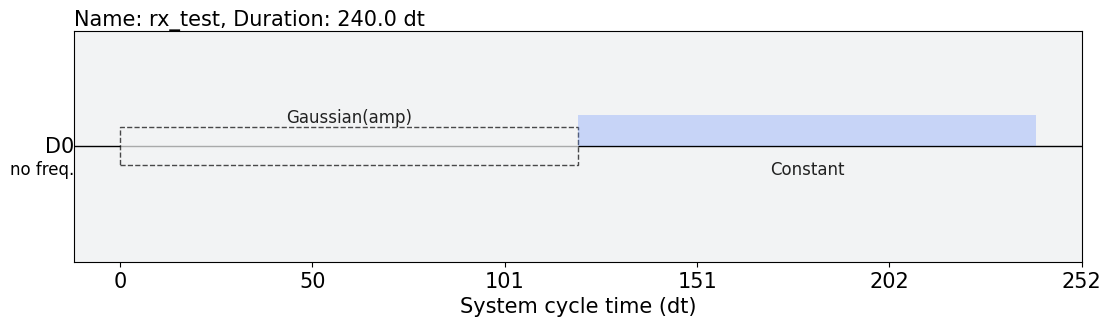

In [2]:
amp = Parameter("amp")
amp2 = Parameter("amp2")
phase = Parameter("phase")
with qp.build(name="rx_test") as sched:
    # qp.set_frequency(0, qp.DriveChannel(0))
    qp.play(
        qp.Gaussian(duration=120, amp=amp, sigma=40, angle=0.0),
        qp.DriveChannel(0),
    )
    qp.play(qp.Constant(duration=120, amp=0.1), qp.DriveChannel(0))

sched.draw()

In [85]:
backend.add_pulse_operations(sched, name="qiskit")

In [57]:
backend.machine.qubits["q1"].xy.operations["qiskit_1"].calculate_waveform()

0.1

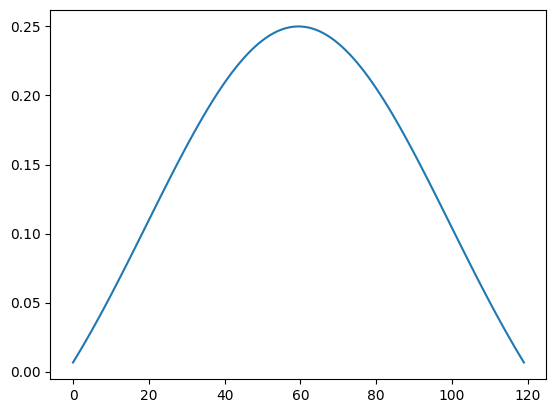

In [86]:
plt.plot(backend.machine.qubits["q1"].xy.operations["qiskit_0"].calculate_waveform())

In [87]:
# These should be changed to your credentials.
from pathlib import Path
import json
from qiskit_qm_provider import ParameterPool

path = Path.home() / "qm_saas_config.json"
with open(path, "r") as f:
    config = json.load(f)
email = config["email"]
password = config["password"]
# Initialize QOP simulator client
client = QmSaas(email=email, password=password, host="qm-saas.dev.quantum-machines.co")

# Choose your QOP version (QOP2.x.y or QOP3.x.y)
version = QoPVersion.latest
ParameterPool.reset()
param_table = ParameterTable.from_qiskit(sched)
client.close_all()

In [88]:
param_table

ParameterTable(rx_test: {Parameter(amp[fixed]))}

In [89]:
# Define a QUA program
with program() as prog:
    param_table.declare_variables()
    assign(param_table.amp, 0.2)
    backend.get_quam_channel(qp.DriveChannel(0)).update_frequency(0)

    with strict_timing_():
        backend.schedule_to_qua_macro(sched, param_table)(**param_table.variables_dict)


# Open quantum machine with the provided configuration and simulate the QUA program

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_33284/1809665654.py:5: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  backend.get_quam_channel(qp.DriveChannel(0)).update_frequency(0)


In [91]:
client.close_all()
config = machine.generate_config()
instance = client.simulator(version=version)
instance.spawn()
# Initialize QuantumMachinesManager with the simulation instance details
qmm = QuantumMachinesManager(
    host=instance.host,
    port=instance.port,
    connection_headers=instance.default_connection_headers,
)
qm = qmm.open_qm(config)
job = qm.simulate(prog, SimulationConfig(int(500), include_analog_waveforms=True))

# Retrieve and handle simulated samples
samples = job.get_simulated_samples()
results = job.result_handles
results.wait_for_all_values()
results

2025-05-05 14:59:31,307 - qm - INFO     - Performing health check
2025-05-05 14:59:31 INFO Performing health check
2025-05-05 14:59:31,646 - qm - INFO     - Cluster healthcheck completed successfully.
2025-05-05 14:59:31 INFO Cluster healthcheck completed successfully.


/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qm/program/_qua_config_schema.py:1956: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


2025-05-05 14:59:33,609 - qm - INFO     - Simulating program.
2025-05-05 14:59:33 INFO Simulating program.


In [90]:
config = machine.generate_config()
print(generate_qua_script(prog))


# Single QUA script generated at 2025-05-05 14:59:07.152185
# QUA library version: 1.2.2rc2+dgx1


from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    v1 = declare(fixed, value=0.0)
    assign(v1, 0.2)
    update_frequency("q1.xy", 0, "Hz", False)
    with strict_timing_():
        assign(v1, v1)
        play("qiskit_0"*amp((3.9998400063997437*v1)), "q1.xy")
        play("qiskit_1", "q1.xy")

config = None

loaded_config = None




In [92]:
from copy import copy

samples = copy(job.get_simulated_samples())

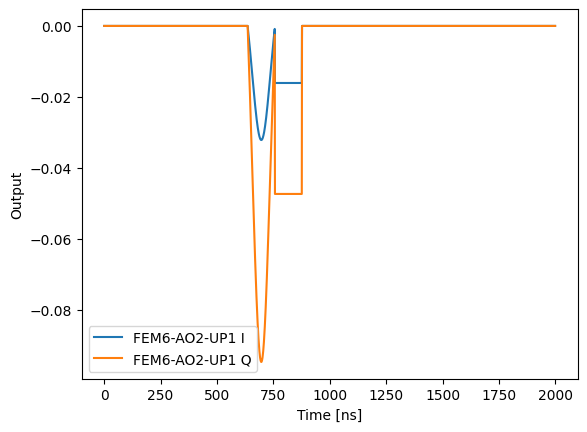

In [68]:
job.get_simulated_samples().con1.plot()

In [83]:
from copy import copy

samples = copy(job.get_simulated_samples().con1)

QMConnectionError: Encountered connection error from QOP: details: Internal Server Error, status: Status.UNKNOWN

In [70]:
instance.close()

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


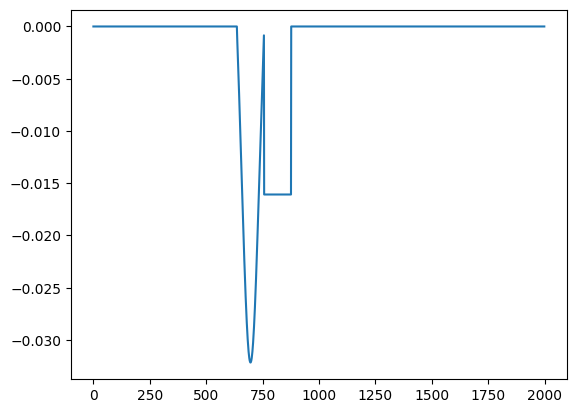

In [82]:
plt.plot(list(samples.analog.values())[0])

# OpenQASM3 to QUA

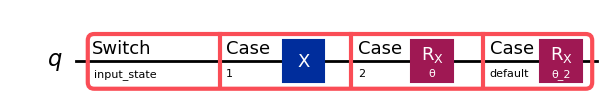

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, Gate, ParameterVector
from qiskit.qasm3 import Exporter, loads
from qiskit.circuit.classical.types import Uint
from qiskit import transpile

qc = QuantumCircuit(1)
theta = Parameter("θ")
theta2 = Parameter("θ_2")
theta3 = ParameterVector("θ_3", 2)
n = Parameter("n")
var = qc.add_input("input_state", Uint(8))
gate = Gate("my_gate", 1, [theta3[0]])
# with qc.for_loop([1, 3, 5]):
#     qc.x(0)
#     qc.rx(theta3[1]*n, 0)
#     qc.append(gate, [0])

with qc.switch(var) as case:
    with case(1):
        qc.x(0)
    with case(2):
        qc.rx(theta, 0)
    with case(case.DEFAULT):
        qc.rx(theta2, 0)
qc.draw("mpl")

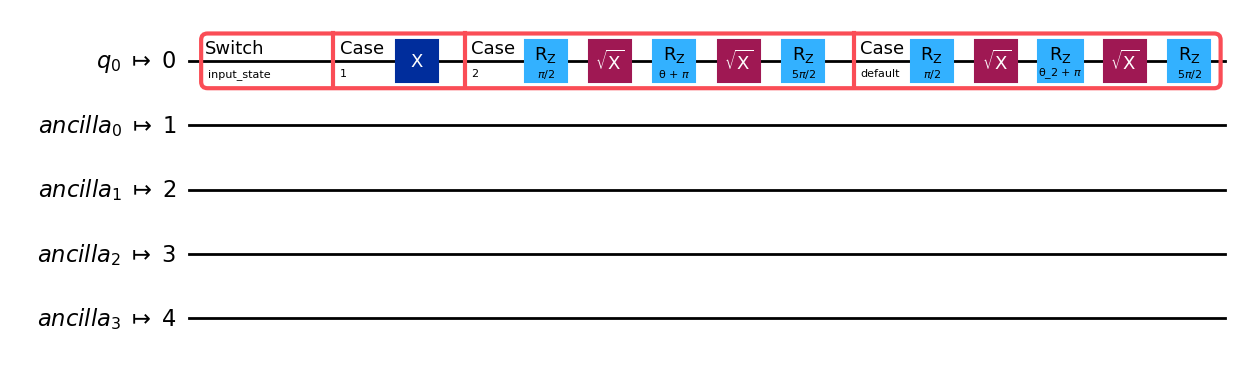

In [18]:
qc = transpile(qc, backend)
qc.draw("mpl")

In [10]:
list(backend._operation_mapping_QUA.keys())[9].name

'reset'

In [2]:
from rl_qoc.rewards.real_time import get_real_time_reward_circuit
from rl_qoc import (
    QEnvConfig,
    QiskitConfig,
    ExecutionConfig,
    BenchmarkConfig,
    GateTargetConfig,
)
from qiskit_qm_provider import ParameterPool
from rl_qoc.qua import QMConfig, QMEnvironment
from gymnasium.spaces import Box


def apply_parameters(qc: QuantumCircuit, params: ParameterVector, qreg: QuantumRegister):
    idx_0 = qreg.index(qreg[0])

    if len(qreg) > 1:
        idx_1 = qreg.index(qreg[1])
        with qp.build(backend) as sched:
            qp.play(qp.Constant(duration=120, amp=0.1), backend.flux_channel(idx_0))
            qp.play(
                qp.Constant(duration=120, amp=params[0]),
                backend.control_channel((idx_0, idx_1))[0],
            )
        qc.add_calibration(
            "rzz",
            [0, 1],
            sched,
            params.params if isinstance(params, ParameterVector) else params,
        )
        qc.rzz(params[0], qreg[0], qreg[1])
    else:
        with qp.build(backend) as sched:
            qp.play(
                qp.Drag(duration=120, amp=params[0], sigma=40, beta=0.2),
                backend.drive_channel(idx_0),
            )
        qc.add_calibration(
            "rx",
            [
                0,
            ],
            sched,
            params.params if isinstance(params, ParameterVector) else params,
        )
        qc.rx(params[0], qreg[0])
    with qp.build(backend, name="x_custom") as sched:
        qp.play(
            qp.Drag(duration=120, amp=0.3, sigma=40, beta=0.2),
            backend.drive_channel(idx_0),
        )
    qc.add_calibration(
        "x",
        [
            0,
        ],
        sched,
    )
    qc.add_calibration(
        "x",
        [
            1,
        ],
        sched,
    )


physical_qubits = [0, 1]
gate = "cz" if len(physical_qubits) > 1 else "x"
n_reps = [2, 5]
config = QEnvConfig(
    target=GateTargetConfig(physical_qubits, gate),
    backend_config=QiskitConfig(
        backend=backend,
        parametrized_circuit=apply_parameters,
    ),
    execution_config=ExecutionConfig(
        batch_size=1,
        n_shots=100,
        n_reps=n_reps,
        control_flow_enabled=True,
    ),
    reward="channel",
    action_space=Box(low=-1, high=1, shape=(1,), dtype=np.float32),
)

qm_config_args = {
    "input_type": "IO1",
    "num_updates": 500,
    "init_macro": backend.machine.apply_all_flux_to_joint_idle,
}
config.backend_config = QMConfig(**config.backend_config.as_dict(), **qm_config_args)

q_env = QMEnvironment(config)

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_38592/3644340201.py:19: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with qp.build(backend) as sched:
/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_38592/3644340201.py:20: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  qp.play(qp.Constant(duration=120, amp=0.1), backend.flux_channel(idx_0))
/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_38592/3644340201.py:21: DeprecationWarning: The function ``qiskit.pulse.builder.play()``

In [15]:
backend.operation_names

['x',
 'rz',
 'sx',
 'measure',
 'reset',
 'cz',
 'if_else',
 'while_loop',
 'for_loop',
 'switch_case']

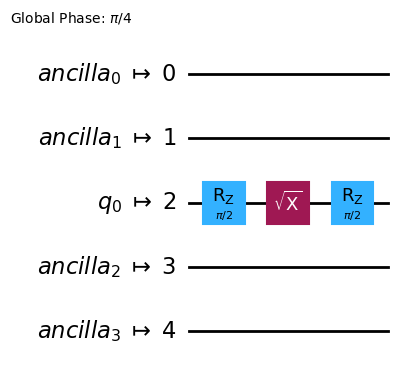

In [16]:
from qiskit import transpile

qc = transpile(qc, backend, initial_layout=[2])
qc.draw("mpl")

In [10]:
from qiskit.qasm3 import Exporter

basis_gates = [op for op in backend.operation_names if op not in ["measure", "reset"]]

exporter = Exporter(includes=(), basis_gates=basis_gates, disable_constants=True)
print(exporter.dumps(qc))

OPENQASM 3.0;
rz(1.5707963267948966) $0;
sx $0;
rz(1.5707963267948966) $0;



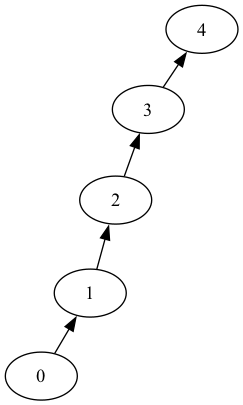

In [12]:
backend.coupling_map.draw()

In [11]:
print(backend.target)

Target: Transmon based QuAM
Number of qubits: 5
Instructions:
	x
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	rz
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	sx
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	measure
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	reset
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	cz
		(0, 1)
		(1, 2)
		(2, 3)
		(3, 4)
	if_else
	while_loop
	for_loop
	switch_case



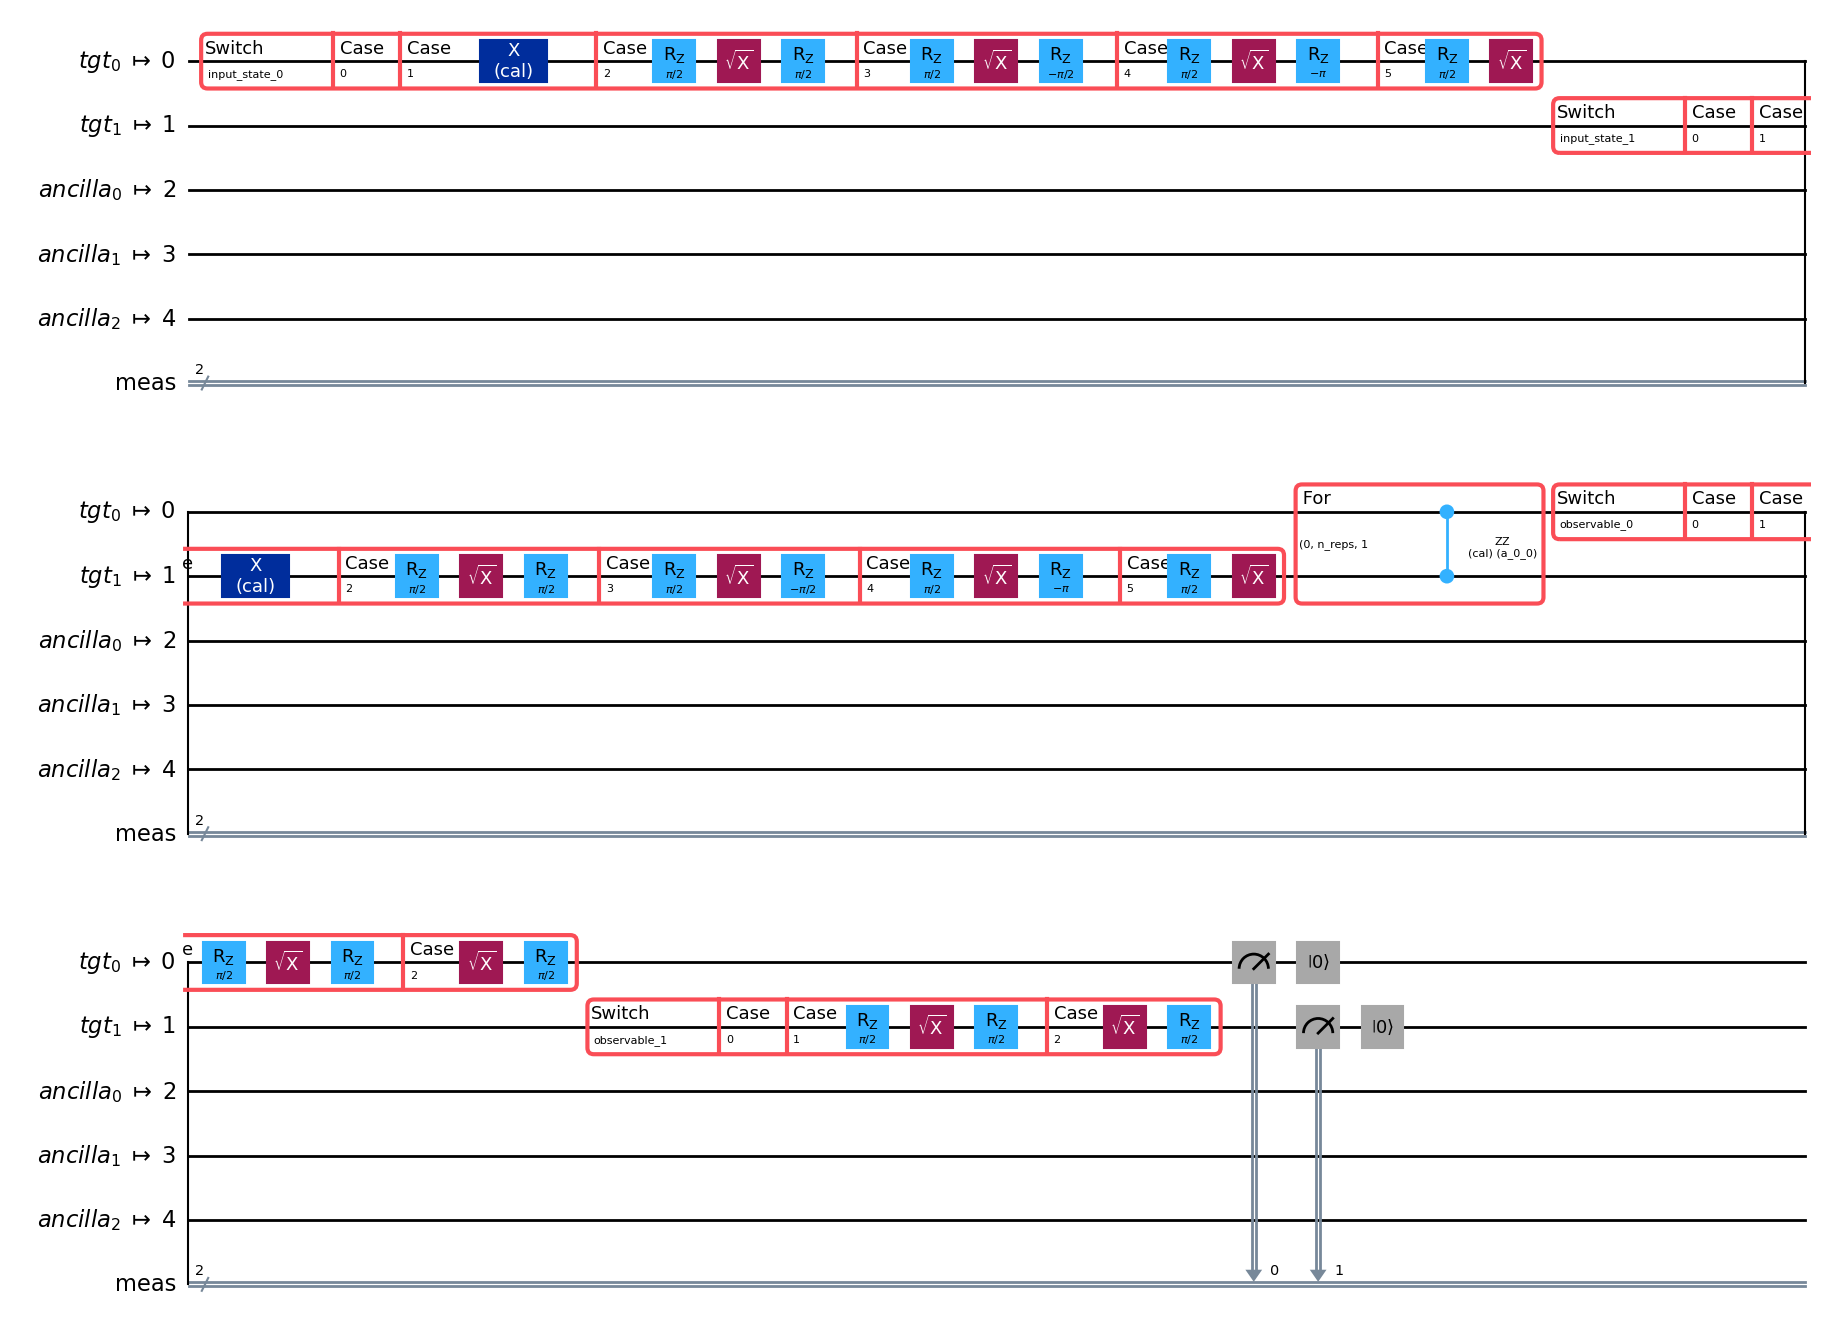

In [3]:
q_env.real_time_circuit.draw("mpl")

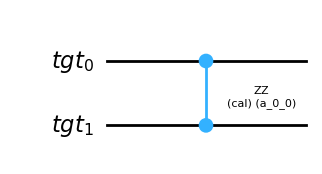

In [17]:
q_env.circuit.draw("mpl")

In [18]:
q_env.circuit.calibrations

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_38592/1176884243.py:1: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.calibrations`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics. Note that once removed, ``qiskit.circuit.quantumcircuit.QuantumCircuit.calibrations`` will have no alternative in Qiskit.
  q_env.circuit.calibrations


{'rzz': {((0, 1),
   (Parameter(a_0_0),)): ScheduleBlock(Play(Constant(duration=120, amp=0.1, angle=0.0, name='block0_0'), FluxChannel(0)), Play(Constant(duration=120, amp=a_0_0, angle=0.0, name='block0_1'), ControlChannel(0)), name="block0", transform=AlignLeft())},
 'x': {((0,),
   ()): ScheduleBlock(Play(Drag(duration=120, sigma=40, beta=0.2, amp=0.3, angle=0.0, name='x_custom_015333655888'), DriveChannel(0)), name="x_custom", transform=AlignLeft()),
  ((1,),
   ()): ScheduleBlock(Play(Drag(duration=120, sigma=40, beta=0.2, amp=0.3, angle=0.0, name='x_custom_015333655888'), DriveChannel(0)), name="x_custom", transform=AlignLeft())}}

In [19]:
from qiskit.qasm3 import Exporter

backend.update_calibrations(q_env.real_time_circuit)
basis_gates = backend.operation_names
print(basis_gates)
# Remove control flow operations, measure and reset from basis gates
basis_gates = [gate for gate in basis_gates if gate not in ["measure", "reset"]]
print(basis_gates)
exporter = Exporter(includes=(), basis_gates=basis_gates, disable_constants=True)

qasm3 = exporter.dumps(q_env.real_time_circuit)
print(qasm3)

/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/parameter_table/parameter.py:120: UserWarning: Parameter with name a_0_0 already exists in parameter table real_time_circuit_parameters.
  warnings.warn(
/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/parameter_table/parameter.py:120: UserWarning: Parameter with name observable_0 already exists in parameter table observable_vars.
  warnings.warn(
/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/parameter_table/parameter.py:120: UserWarning: Parameter with name n_reps already exists in parameter table real_time_qc_param_table.
  warnings.warn(
/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/parameter_table/parameter.py:120: UserWarning: Parameter with name observable_1 already exists in param

ValueError: Parameter with name real_time_qc_param_table already exists.

In [7]:
q_env.backend._oq3_custom_gates

['x', 'rzz']

In [2]:
from qiskit_qm_provider import ParameterPool

ParameterPool.get_all()

{}

In [56]:
list(ParameterPool.get_all_objs())[1].name

IndexError: list index out of range

In [31]:
list(ParameterPool.get_all_objs())[3].stream_id

4

In [32]:
ParameterPool.get_obj(3).get_parameter("input_state_1")._table_indices

{'ParameterTable_14991319376': 1,
 'ParameterTable_14963846608': 5,
 'ParameterTable_15011464080': 5}

In [60]:
list(ParameterPool.get_all_objs())[2]

IndexError: list index out of range

In [9]:
q_env.real_time_circuit.metadata["parameter_table"]

ParameterTable(Parameter(name=a_0_0, value=0.0, type=<class 'qm.qua._expressions.fixed'>, length=0, input_type=IO1, direction=OUTGOING, units=), Parameter(name=input_state_0, value=0, type=<class 'int'>, length=0, input_type=IO1, direction=OUTGOING, units=), Parameter(name=input_state_1, value=0, type=<class 'int'>, length=0, input_type=IO1, direction=OUTGOING, units=), Parameter(name=observable_1, value=0, type=<class 'int'>, length=0, input_type=IO1, direction=OUTGOING, units=), Parameter(name=observable_0, value=0, type=<class 'int'>, length=0, input_type=IO1, direction=OUTGOING, units=), Parameter(name=n_reps, value=0, type=<class 'int'>, length=0, input_type=IO1, direction=OUTGOING, units=), )

In [10]:
result = q_env.backend.quantum_circuit_to_qua(q_env.real_time_circuit).result_program

In [7]:
result["meas"]

In [8]:
q_env.real_time_circuit.iter_input_vars()

dict_values([Var(5c83651f-ac29-4a00-96bc-569aa362f3c3, Uint(8), name='n_reps'), Var(79928fcb-c37a-41a7-801c-6a61b27f0a19, Uint(4), name='observable_1'), Var(ca50980c-4c06-4dd1-b48b-75024e5019b6, Uint(4), name='observable_0'), Var(4465d6f5-bb30-4892-b0b4-dff812c8f0b4, Uint(4), name='input_state_1'), Var(a859f3dc-2bf0-4088-9ce9-ef3d90da4d2c, Uint(4), name='input_state_0')])

In [11]:
from qm import generate_qua_script

print(generate_qua_script(result.dsl_program))


# Single QUA script generated at 2025-05-01 17:27:25.654822
# QUA library version: 1.2.2rc2+dgx1


from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    input_stream_a_0_0 = declare_input_stream(fixed, 'a_0_0', value=0.0)
    input_stream_input_state_0 = declare_input_stream(int, 'input_state_0', value=0)
    input_stream_input_state_1 = declare_input_stream(int, 'input_state_1', value=0)
    input_stream_observable_1 = declare_input_stream(int, 'observable_1', value=0)
    input_stream_observable_0 = declare_input_stream(int, 'observable_0', value=0)
    input_stream_n_reps = declare_input_stream(int, 'n_reps', value=0)
    a1 = declare(bool, value=[False, False])
    v1 = declare(int, value=0)
    v2 = declare(int, value=0)
    v3 = declare(int, value=0)
    v4 = declare(int, value=0)
    v5 = declare(int, value=0)
    v6 = declare(fixed, value=0.0)
    v7 = declare(int, )
    v8 = declare(fixed, )
    v9 = declare(fixed, )
    v10 = declare(fixed,

In [12]:
print(generate_qua_script(q_env.rl_qoc_training_qua_prog()))

/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/qua/parameter_table/parameter_table.py:248: UserWarning: Variable a_0_0 already declared.
  continue



# Single QUA script generated at 2025-05-01 17:28:27.432256
# QUA library version: 1.2.2rc2+dgx1


from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    v1 = declare(int, value=0)
    v2 = declare(int, value=0)
    v3 = declare(int, value=0)
    a1 = declare(fixed, value=[0.0])
    v4 = declare(int, )
    a2 = declare(fixed, value=[1.0])
    v5 = declare(int, )
    a3 = declare(int, value=[0, 0, 0, 0])
    v6 = declare(int, )
    v7 = declare(int, value=0)
    v8 = declare(int, value=0)
    v9 = declare(int, value=0)
    v10 = declare(int, )
    v11 = declare(int, value=0)
    v12 = declare(int, value=100)
    v13 = declare(int, )
    v14 = declare(int, )
    v15 = declare(int, )
    v16 = declare(int, )
    a4 = declare(fixed, value=[-1.0])
    a5 = declare(fixed, value=[1.0])
    v17 = declare(int, )
    a6 = declare(fixed, value=[1.0, 0.9999247018391445, 0.9996988186962042, 0.9993223845883495, 0.9987954562051724, 0.9981181129001492, 0.997290456678

In [2]:
from rl_qoc.rewards import ChannelReward, CAFEReward, StateReward
import numpy as np

reward = ChannelReward()
reward_data = reward.get_reward_data(
    q_env.circuits[0], np.zeros((1, q_env.n_actions)), q_env.target, q_env.config
)

NameError: name 'q_env' is not defined

In [56]:
reward_data.fiducials_indices

[((3, 0), [(1, 3)]),
 ((3, 1), [(1, 3)]),
 ((2, 1), [(1, 3)]),
 ((2, 0), [(1, 3)]),
 ((5, 1), [(2, 3)]),
 ((5, 0), [(2, 3)]),
 ((4, 0), [(2, 3)]),
 ((4, 1), [(2, 3)]),
 ((1, 0), [(3, 3)]),
 ((0, 0), [(3, 3)]),
 ((0, 1), [(3, 3)]),
 ((1, 1), [(3, 3)]),
 ((1, 2), [(3, 1)]),
 ((0, 2), [(3, 1)]),
 ((0, 3), [(3, 1)]),
 ((1, 3), [(3, 1)]),
 ((2, 3), [(1, 1)]),
 ((3, 3), [(1, 1)]),
 ((2, 2), [(1, 1)]),
 ((3, 2), [(1, 1)]),
 ((4, 2), [(2, 1)]),
 ((5, 2), [(2, 1)]),
 ((5, 3), [(2, 1)]),
 ((4, 3), [(2, 1)]),
 ((1, 4), [(3, 2)]),
 ((0, 4), [(3, 2)]),
 ((0, 5), [(3, 2)]),
 ((1, 5), [(3, 2)]),
 ((2, 5), [(1, 2)]),
 ((3, 4), [(1, 2)]),
 ((2, 4), [(1, 2)]),
 ((3, 5), [(1, 2)]),
 ((5, 5), [(2, 2)]),
 ((5, 4), [(2, 2)]),
 ((4, 5), [(2, 2)]),
 ((4, 4), [(2, 2)])]

In [68]:
reward_data[10].observables

SparsePauliOp(['IZ', 'ZI', 'ZZ'],
              coeffs=[ 1.  +0.j, -1.5 +0.j, -1.25+0.j])

In [69]:
reward_data[10].hamiltonian

SparsePauliOp(['IZ', 'ZI', 'ZZ'],
              coeffs=[ 1.  +0.j, -1.5 +0.j, -1.25+0.j])

In [22]:
reward_data.input_indices

[(3, 0),
 (3, 1),
 (2, 1),
 (2, 0),
 (5, 1),
 (5, 0),
 (4, 0),
 (4, 1),
 (1, 0),
 (0, 0),
 (0, 1),
 (1, 1),
 (1, 2),
 (0, 2),
 (0, 3),
 (1, 3),
 (2, 3),
 (3, 3),
 (2, 2),
 (3, 2),
 (4, 2),
 (5, 2),
 (5, 3),
 (4, 3),
 (1, 4),
 (0, 4),
 (0, 5),
 (1, 5),
 (2, 5),
 (3, 4),
 (2, 4),
 (3, 5),
 (5, 5),
 (5, 4),
 (4, 5),
 (4, 4)]

In [13]:
reward_data.observables_indices

[[(1, 3)],
 [(1, 3)],
 [(1, 3)],
 [(1, 3)],
 [(2, 3)],
 [(2, 3)],
 [(2, 3)],
 [(2, 3)],
 [(3, 3)],
 [(3, 3)],
 [(3, 3)],
 [(3, 3)],
 [(3, 1)],
 [(3, 1)],
 [(3, 1)],
 [(3, 1)],
 [(1, 1)],
 [(1, 1)],
 [(1, 1)],
 [(1, 1)],
 [(2, 1)],
 [(2, 1)],
 [(2, 1)],
 [(2, 1)],
 [(3, 2)],
 [(3, 2)],
 [(3, 2)],
 [(3, 2)],
 [(1, 2)],
 [(1, 2)],
 [(1, 2)],
 [(1, 2)],
 [(2, 2)],
 [(2, 2)],
 [(2, 2)],
 [(2, 2)]]

In [11]:
from rl_qoc.rewards import ChannelReward, CAFEReward, StateReward
import numpy as np

reward = CAFEReward()
reward_data = reward.get_reward_data(
    q_env.circuits[0], np.zeros((1, q_env.n_actions)), q_env.target, q_env.config
)

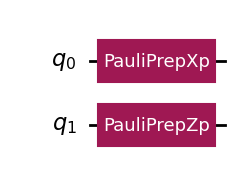

In [19]:
reward_data.input_circuits[8].draw("mpl")

In [42]:
param_table.get_parameter(0)

ChannelRewardData(pub=EstimatorPub(<(1,)>), input_circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3865147d0>, observables=SparsePauliOp(['X'],
              coeffs=[-13.+0.j]), shots=1300, n_reps=1, causal_cone_qubits_indices=[0], input_pauli=Pauli('X'), input_indices=(3,), observables_indices=[(1,)])

In [77]:
from qiskit.pulse.transforms import block_to_schedule

with qp.build(backend) as sched2:
    qp.call(sched)
    qp.acquire(100, qp.AcquireChannel(0), qp.MemorySlot(0))
    qp.measure_all()

block_to_schedule(sched2)

False

In [19]:
from qiskit_ibm_runtime.fake_provider.backends import FakeAthensV2

In [30]:
backend2 = FakeAthensV2()

backend2.target["measure"][(0,)].calibration.instructions

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_34461/1007896907.py:3: DeprecationWarning: The property ``qiskit.transpiler.target.InstructionProperties.calibration`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics. Note that once removed, ``qiskit.transpiler.target.InstructionProperties.calibration`` will have no alternative in Qiskit.
  backend2.target["measure"][(0,)].calibration.instructions


((0, Acquire(9776, AcquireChannel(0), MemorySlot(0), , , )),
 (0, Acquire(9776, AcquireChannel(1), MemorySlot(1), , , )),
 (0, Acquire(9776, AcquireChannel(2), MemorySlot(2), , , )),
 (0, Acquire(9776, AcquireChannel(3), MemorySlot(3), , , )),
 (0, Acquire(9776, AcquireChannel(4), MemorySlot(4), , , )),
 (0,
  Play(GaussianSquare(duration=9776, sigma=64, width=9520, amp=0.08, angle=-0.3129182953764417, name='gaussian_square_7ee7'), MeasureChannel(0), name='gaussian_square_7ee7')),
 (9776, Delay(3824, MeasureChannel(0))))

In [27]:
backend2.target["reset"]

{(0,): InstructionProperties(duration=3.431111111111111e-06, error=None, calibration=None),
 (1,): InstructionProperties(duration=3.431111111111111e-06, error=None, calibration=None),
 (2,): InstructionProperties(duration=3.431111111111111e-06, error=None, calibration=None),
 (3,): InstructionProperties(duration=3.431111111111111e-06, error=None, calibration=None),
 (4,): InstructionProperties(duration=3.431111111111111e-06, error=None, calibration=None)}

In [3]:
from qiskit_qm_provider.quam_qiskit_pulse import FluxChannel

with qp.build(backend) as sched:
    print(qp.qubit_channels(2))
    qp.play(
        qp.Gaussian(duration=120, amp=0.1, sigma=40),
        FluxChannel(2),
    )

{MeasureChannel(2), AcquireChannel(2), DriveChannel(2)}


In [25]:
backend.channel_mapping[qp.ControlChannel(3)].name

'coupler_q4_q5'

In [45]:
backend.control_channel((1, 0))

ValueError: Control channel not found for qubit pair [1, 0] in the channel mapping